<a href="https://colab.research.google.com/github/AbeAdeloye/Tumor-classifcation-MRI-/blob/main/Brain_tumor_classification_using_ANN%2C_CNN_(_and_TL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PACKAGES AND LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from keras import models
from keras import layers
import tensorflow as tf
import os
import os.path
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from tensorflow.keras.optimizers import RMSprop,Adam

#### IGNORING WARNINGS


In [ ]:
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

#### Data collection and Augmentation


In [ ]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 30.36 MiB/s, done.


In [ ]:
import tensorflow as tf
import os
import os.path

from shutil import copyfile
from os import getcwd
from os import listdir
from pathlib import Path
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_data(file_dir, n_generated_samples, save_to_dir):
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        #print(file_dir + '/' + filename)
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break



data_path = '/content/Brain-Tumor-Classification-DataSet/Training/'
for folder in listdir(data_path):
  augment_data(file_dir=data_path+folder, n_generated_samples=1, save_to_dir=data_path+folder)

# PATH PROCESS

#### TRAIN

In [ ]:
Train_Data_Path = Path("/content/Brain-Tumor-Classification-DataSet/Training")

In [ ]:
Train_JPG_Path = list(Train_Data_Path.glob(r"*/*.jpg"))

In [ ]:
print(Train_JPG_Path[0:10])

[PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(11).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(16)_0_9338.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(102)_0_8317.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(278)_0_1525.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(170)_0_1999.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(156)_0_5842.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image(311)_0_3137.jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(141).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/image(121).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Training/no_tumor/aug_image (47)_0_5136.jpg')]


In [ ]:
Train_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_JPG_Path))

In [ ]:
print("NO: ",Train_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Train_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Train_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Train_JPG_Labels.count("glioma_tumor"))

NO:  1185
Pituitary:  2481
Meningioma:  2466
Glioma:  2478


In [ ]:
Train_JPG_Path_Series = pd.Series(Train_JPG_Path,name="JPG").astype(str)
Train_JPG_Labels_Series = pd.Series(Train_JPG_Labels, name="TUMOR_CATEGORY")

In [ ]:
print(Train_JPG_Path_Series.head())
print("-----"*20)
print(Train_JPG_Labels_Series.head())

0    /content/Brain-Tumor-Classification-DataSet/Tr...
1    /content/Brain-Tumor-Classification-DataSet/Tr...
2    /content/Brain-Tumor-Classification-DataSet/Tr...
3    /content/Brain-Tumor-Classification-DataSet/Tr...
4    /content/Brain-Tumor-Classification-DataSet/Tr...
Name: JPG, dtype: object
----------------------------------------------------------------------------------------------------
0    no_tumor
1    no_tumor
2    no_tumor
3    no_tumor
4    no_tumor
Name: TUMOR_CATEGORY, dtype: object


In [ ]:
Main_Train_Data = pd.concat([Train_JPG_Path_Series,Train_JPG_Labels_Series],axis=1)

In [ ]:
print(Main_Train_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
1  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
2  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
3  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor
4  /content/Brain-Tumor-Classification-DataSet/Tr...       no_tumor


#### TEST

In [ ]:
Test_Data_Path = Path("/content/Brain-Tumor-Classification-DataSet/Testing")

In [ ]:
Test_JPG_Path = list(Test_Data_Path.glob(r"*/*.jpg"))

In [ ]:
print(Test_JPG_Path[0:5])

[PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(11).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(42).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(57).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(96).jpg'), PosixPath('/content/Brain-Tumor-Classification-DataSet/Testing/no_tumor/image(21).jpg')]


In [ ]:
Test_JPG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_JPG_Path))

In [ ]:
print("NO: ",Test_JPG_Labels.count("no_tumor"))
print("Pituitary: ",Test_JPG_Labels.count("pituitary_tumor"))
print("Meningioma: ",Test_JPG_Labels.count("meningioma_tumor"))
print("Glioma: ",Test_JPG_Labels.count("glioma_tumor"))

NO:  105
Pituitary:  74
Meningioma:  115
Glioma:  100


In [ ]:
Test_JPG_Path_Series = pd.Series(Test_JPG_Path,name="JPG").astype(str)
Test_JPG_Labels_Labels = pd.Series(Test_JPG_Labels,name="TUMOR_CATEGORY")

In [ ]:
print(Test_JPG_Path_Series.head())
print("-----"*20)
print(Test_JPG_Labels_Labels.head())

0    /content/Brain-Tumor-Classification-DataSet/Te...
1    /content/Brain-Tumor-Classification-DataSet/Te...
2    /content/Brain-Tumor-Classification-DataSet/Te...
3    /content/Brain-Tumor-Classification-DataSet/Te...
4    /content/Brain-Tumor-Classification-DataSet/Te...
Name: JPG, dtype: object
----------------------------------------------------------------------------------------------------
0    no_tumor
1    no_tumor
2    no_tumor
3    no_tumor
4    no_tumor
Name: TUMOR_CATEGORY, dtype: object


In [ ]:
Main_Test_Data = pd.concat([Test_JPG_Path_Series,Test_JPG_Labels_Labels],axis=1)

In [ ]:
print(Main_Test_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
1  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
2  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
3  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor
4  /content/Brain-Tumor-Classification-DataSet/Te...       no_tumor


# SHUFFLING

In [ ]:
Main_Train_Data = Main_Train_Data.sample(frac=1).reset_index(drop=True)
Main_Test_Data = Main_Test_Data.sample(frac=1).reset_index(drop=True)

In [ ]:
print(Main_Train_Data.head(10))
print("----"*20)
print(Main_Test_Data.head(10))

                                                 JPG    TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
1  /content/Brain-Tumor-Classification-DataSet/Tr...      glioma_tumor
2  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
3  /content/Brain-Tumor-Classification-DataSet/Tr...      glioma_tumor
4  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
5  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
6  /content/Brain-Tumor-Classification-DataSet/Tr...          no_tumor
7  /content/Brain-Tumor-Classification-DataSet/Tr...          no_tumor
8  /content/Brain-Tumor-Classification-DataSet/Tr...   pituitary_tumor
9  /content/Brain-Tumor-Classification-DataSet/Tr...  meningioma_tumor
--------------------------------------------------------------------------------
                                                 JPG    TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...      glioma_tu

# REPLACE NAME

In [ ]:
Main_Train_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

In [ ]:
print(Main_Train_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Tr...      Pituitary
1  /content/Brain-Tumor-Classification-DataSet/Tr...         Glioma
2  /content/Brain-Tumor-Classification-DataSet/Tr...     Meningioma
3  /content/Brain-Tumor-Classification-DataSet/Tr...         Glioma
4  /content/Brain-Tumor-Classification-DataSet/Tr...     Meningioma


In [ ]:
Main_Test_Data["TUMOR_CATEGORY"].replace({"glioma_tumor":"Glioma",
                                         "meningioma_tumor":"Meningioma",
                                         "no_tumor":"No",
                                         "pituitary_tumor":"Pituitary"},inplace=True)

In [ ]:
print(Main_Test_Data.head())

                                                 JPG TUMOR_CATEGORY
0  /content/Brain-Tumor-Classification-DataSet/Te...         Glioma
1  /content/Brain-Tumor-Classification-DataSet/Te...     Meningioma
2  /content/Brain-Tumor-Classification-DataSet/Te...      Pituitary
3  /content/Brain-Tumor-Classification-DataSet/Te...     Meningioma
4  /content/Brain-Tumor-Classification-DataSet/Te...             No


# VISUALIZATION

#### TRAIN

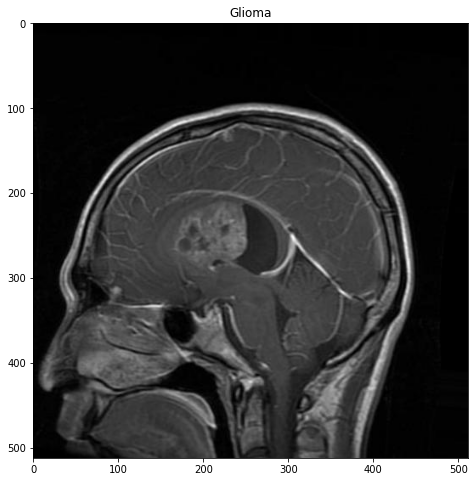

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][10],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][10])
plt.show()

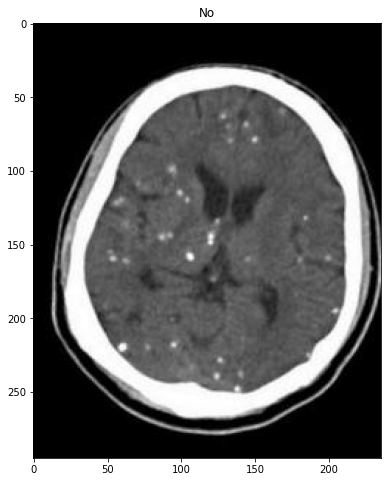

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][7],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][7])
plt.show()

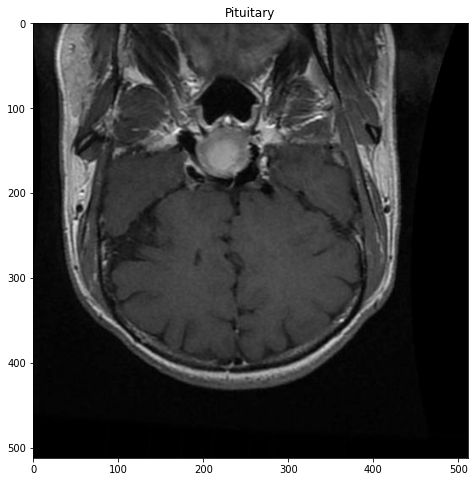

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Train_Data["JPG"][200],0))
plt.title(Main_Train_Data["TUMOR_CATEGORY"][200])
plt.show()

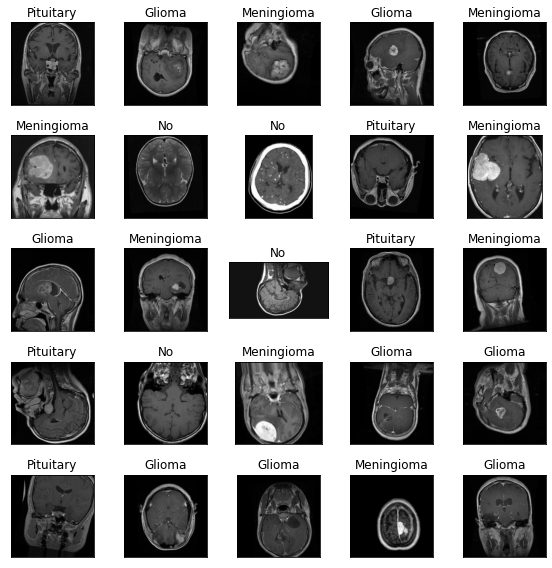

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Train_Data["JPG"][i]))
    ax.set_title(Main_Train_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

#### TEST

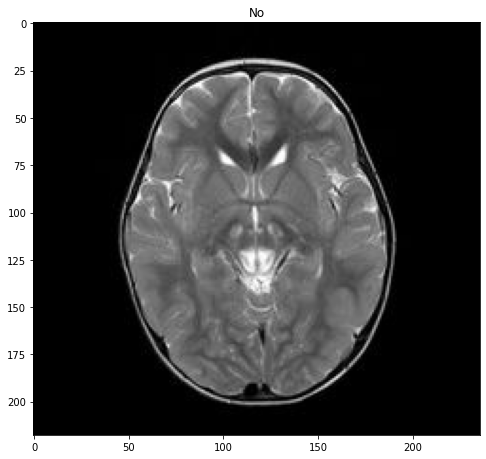

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][200],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][200])
plt.show()

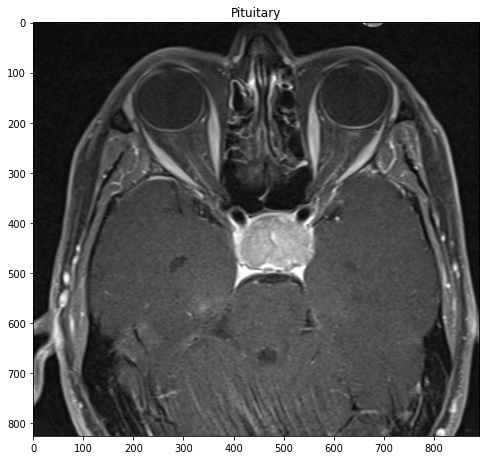

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][2],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][2])
plt.show()

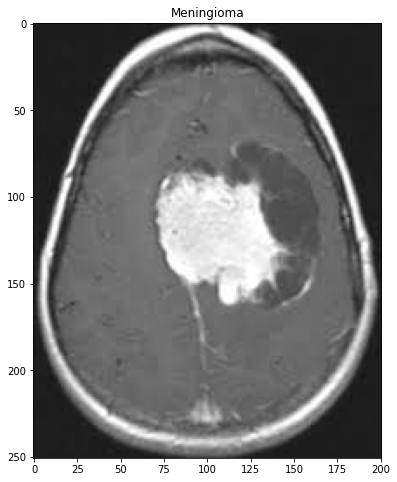

In [ ]:
figure = plt.figure(figsize=(8,8))
plt.imshow(plt.imread(Main_Test_Data["JPG"][12],0))
plt.title(Main_Test_Data["TUMOR_CATEGORY"][12])
plt.show()

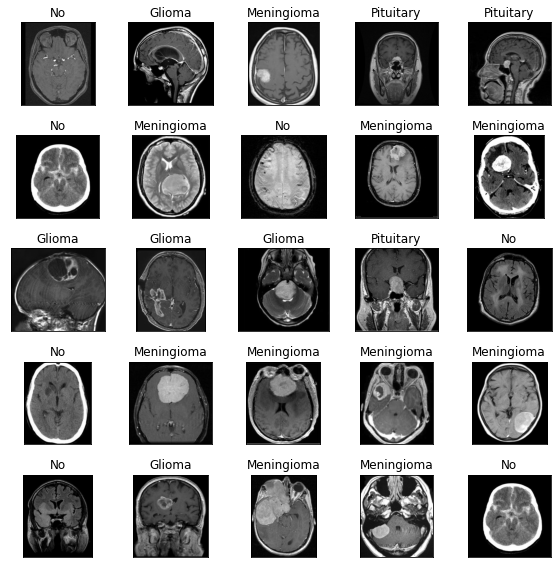

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"][i]))
    ax.set_title(Main_Test_Data["TUMOR_CATEGORY"][i])
plt.tight_layout()
plt.show()

# MODEL TRAINING DATA

In [ ]:
train_data,test_data = train_test_split(Main_Train_Data,train_size=0.9,random_state=42)

In [ ]:
print(train_data.shape)

(7749, 2)


In [ ]:
print(test_data.shape)

(861, 2)


# IMAGE GENERATOR

In [ ]:
Generator = ImageDataGenerator(rescale=1./255,
                               brightness_range=[0.2,0.9],
                               featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=0,
        zoom_range = 0,
        width_shift_range=0,  
        height_shift_range=0, validation_split=0.1)

In [ ]:
Train_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                         x_col="JPG",
                                         y_col="TUMOR_CATEGORY",
                                         seed=42,
                                          color_mode="rgb",
                                         class_mode="categorical",
                                          batch_size=10,
                                         subset="training"
                                         )

Found 6975 validated image filenames belonging to 4 classes.


In [ ]:
print(Train_Set.class_indices)
print(Train_Set.classes[0:5])
print(Train_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[2, 2, 3, 3, 0]
(256, 256, 3)


In [ ]:
Validation_Set = Generator.flow_from_dataframe(dataframe=train_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10,
                                               subset="validation"
                                              )

Found 774 validated image filenames belonging to 4 classes.


In [ ]:
print(Validation_Set.class_indices)
print(Validation_Set.classes[0:5])
print(Validation_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[3, 0, 3, 3, 1]
(256, 256, 3)


In [ ]:
Test_Set = Generator.flow_from_dataframe(dataframe=test_data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=10
                                              )

Found 861 validated image filenames belonging to 4 classes.


In [ ]:
print(Test_Set.class_indices)
print(Test_Set.classes[0:5])
print(Test_Set.image_shape)

{'Glioma': 0, 'Meningioma': 1, 'No': 2, 'Pituitary': 3}
[1, 0, 0, 0, 3]
(256, 256, 3)


# ANN MODEL

In [ ]:
Model = Sequential()
#
Model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu', input_shape = (256,256,3)))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

# 
Model.add(Flatten())
Model.add(Dense(256, activation = "relu"))
Model.add(Dropout(0.25))
Model.add(Dense(4, activation = "softmax"))

In [ ]:
Model.compile(optimizer=RMSprop(lr=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=2,mode="min")

In [ ]:
ANN_Model = Model.fit(Train_Set,
                      validation_data=Validation_Set,
                     epochs=2,
                      batch_size=20,
                     callbacks=Call_Back)

Epoch 1/2
698/698 [==============================] - 74s 106ms/step - loss: 0.6585 - accuracy: 0.7534 - val_loss: 0.8117 - val_accuracy: 0.6860
Epoch 2/2
698/698 [==============================] - 74s 105ms/step - loss: 0.6888 - accuracy: 0.7507 - val_loss: 0.8308 - val_accuracy: 0.7003


In [ ]:
Model_Results = Model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.2f" % Model_Results[1])

LOSS:  0.6875
ACCURACY:  0.73


In [ ]:
print(Model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

No handles with labels found to put in legend.


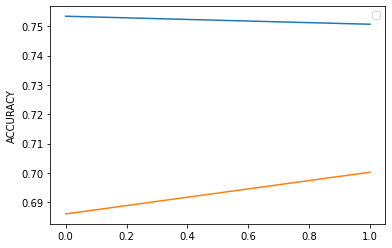

In [ ]:
plt.plot(ANN_Model.history["accuracy"])
plt.plot(ANN_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.show()

## ANN Model 2 with 2 Layers more

In [ ]:
Model2 = Sequential()
#
Model2.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 activation ='relu', input_shape = (256,256,3)))
Model2.add(MaxPool2D(pool_size=(2,2)))
Model.add(Dropout(0.2))

#
Model2.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))
Model2.add(MaxPool2D(pool_size=(2,2)))
Model2.add(Dropout(0.2))


Model2.add(Flatten())
Model2.add(Dense(256, activation = "relu"))
Model2.add(Dropout(0.25))
Model2.add(Dense(4, activation = "softmax"))

In [ ]:
Model2.compile(optimizer=RMSprop(lr=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
Call_Back = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=2,mode="min")

In [ ]:
ANN_Model2 = Model2.fit(Train_Set,
                      validation_data=Validation_Set,
                     epochs=2,
                      batch_size=20,
                     callbacks=Call_Back)

Epoch 1/2
698/698 [==============================] - 134s 192ms/step - loss: 1.1289 - accuracy: 0.4986 - val_loss: 1.0088 - val_accuracy: 0.6021
Epoch 2/2
698/698 [==============================] - 134s 192ms/step - loss: 0.8220 - accuracy: 0.6634 - val_loss: 0.8502 - val_accuracy: 0.6576


In [ ]:
Model2_Results = Model2.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % Model2_Results[0])
print("ACCURACY:  " + "%.2f" % Model2_Results[1])

LOSS:  0.7888
ACCURACY:  0.68


In [ ]:
HistoryDict = ANN_Model.history

val_losses = HistoryDict["val_loss"]
val_acc = HistoryDict["val_accuracy"]
acc = HistoryDict["accuracy"]
losses = HistoryDict["loss"]
epochs = range(1,len(val_losses)+1)

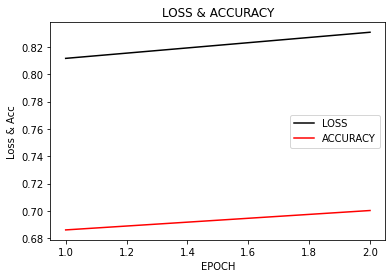

In [ ]:
plt.plot(epochs,val_losses,"k-",label="LOSS")
plt.plot(epochs,val_acc,"r",label="ACCURACY")
plt.title("LOSS & ACCURACY")
plt.xlabel("EPOCH")
plt.ylabel("Loss & Acc")
plt.legend()
plt.show()

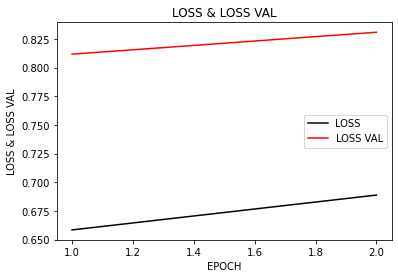

In [ ]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"r",label="LOSS VAL")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

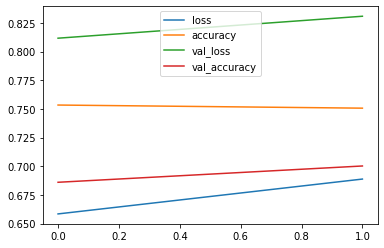

In [ ]:
Dict_Summary = pd.DataFrame(ANN_Model.history)
Dict_Summary.plot()

# PREDICTION PROCESS

In [ ]:
Main_Test_Set = Generator.flow_from_dataframe(dataframe=Main_Test_Data,
                                              x_col="JPG",
                                              y_col="TUMOR_CATEGORY",
                                              seed=42,
                                               color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=20
                                              )

Found 394 validated image filenames belonging to 4 classes.


In [ ]:
Model_Predict = Model.predict(Main_Test_Set)
Model_Predict2=Model2.predict(Main_Test_Set)

In [ ]:
Model_Predict = np.argmax(Model_Predict,axis=1)
Model_Predict2 = np.argmax(Model_Predict2,axis=1)

In [ ]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())


In [ ]:
Model_Predict = [Predict_Label[k] for k in Model_Predict]
Model_Predict2 = [Predict_Label[k] for k in Model_Predict2]

In [ ]:
print(Model_Predict[:50])

['No', 'No', 'No', 'No', 'No', 'Glioma', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Pituitary', 'Pituitary', 'Meningioma', 'No', 'No', 'No', 'Glioma', 'No', 'Meningioma', 'No', 'Glioma', 'No', 'Meningioma', 'No', 'Pituitary', 'Pituitary', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary', 'Pituitary', 'No', 'No', 'No', 'Glioma', 'Glioma', 'No', 'No', 'Meningioma', 'No', 'Meningioma', 'Pituitary', 'Pituitary', 'Glioma', 'Pituitary', 'No']


In [ ]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])

In [ ]:
print(Test_Results[:50])

['Glioma', 'Meningioma', 'Pituitary', 'Meningioma', 'No', 'Pituitary', 'Glioma', 'Glioma', 'No', 'Glioma', 'Glioma', 'No', 'Meningioma', 'No', 'Glioma', 'No', 'Pituitary', 'No', 'No', 'No', 'Glioma', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'Glioma', 'No', 'Glioma', 'Pituitary', 'No', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma']


In [ ]:
print("Compartison")
print("Class_Report")
Class_Report = classification_report(Test_Results,Model_Predict)
print(Class_Report)
#2
Class_Report2 = classification_report(Test_Results,Model_Predict2)
print("Class_Report2")
print(Class_Report2)

Compartison
Class_Report
              precision    recall  f1-score   support

      Glioma       0.39      0.09      0.15       100
  Meningioma       0.29      0.24      0.26       115
          No       0.29      0.57      0.39       105
   Pituitary       0.25      0.23      0.24        74

    accuracy                           0.29       394
   macro avg       0.30      0.28      0.26       394
weighted avg       0.31      0.29      0.26       394

Class_Report2
              precision    recall  f1-score   support

      Glioma       0.27      0.07      0.11       100
  Meningioma       0.33      0.40      0.36       115
          No       0.24      0.36      0.29       105
   Pituitary       0.17      0.16      0.17        74

    accuracy                           0.26       394
   macro avg       0.25      0.25      0.23       394
weighted avg       0.26      0.26      0.24       394



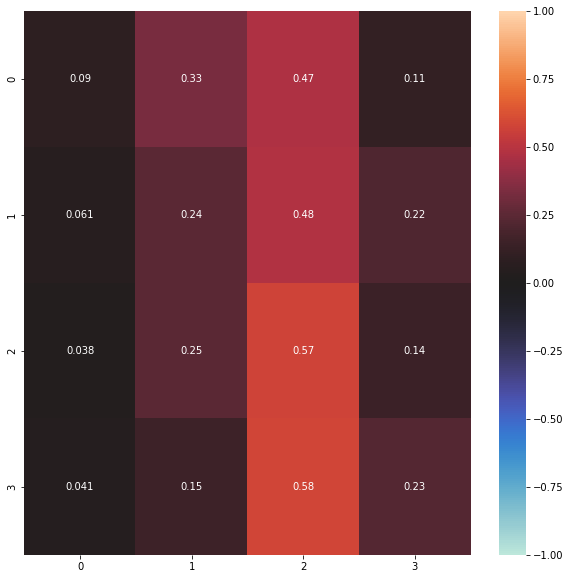

In [ ]:
Conf_Report = confusion_matrix(Test_Results,Model_Predict, normalize="true")
figure = plt.figure(figsize=(10,10))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

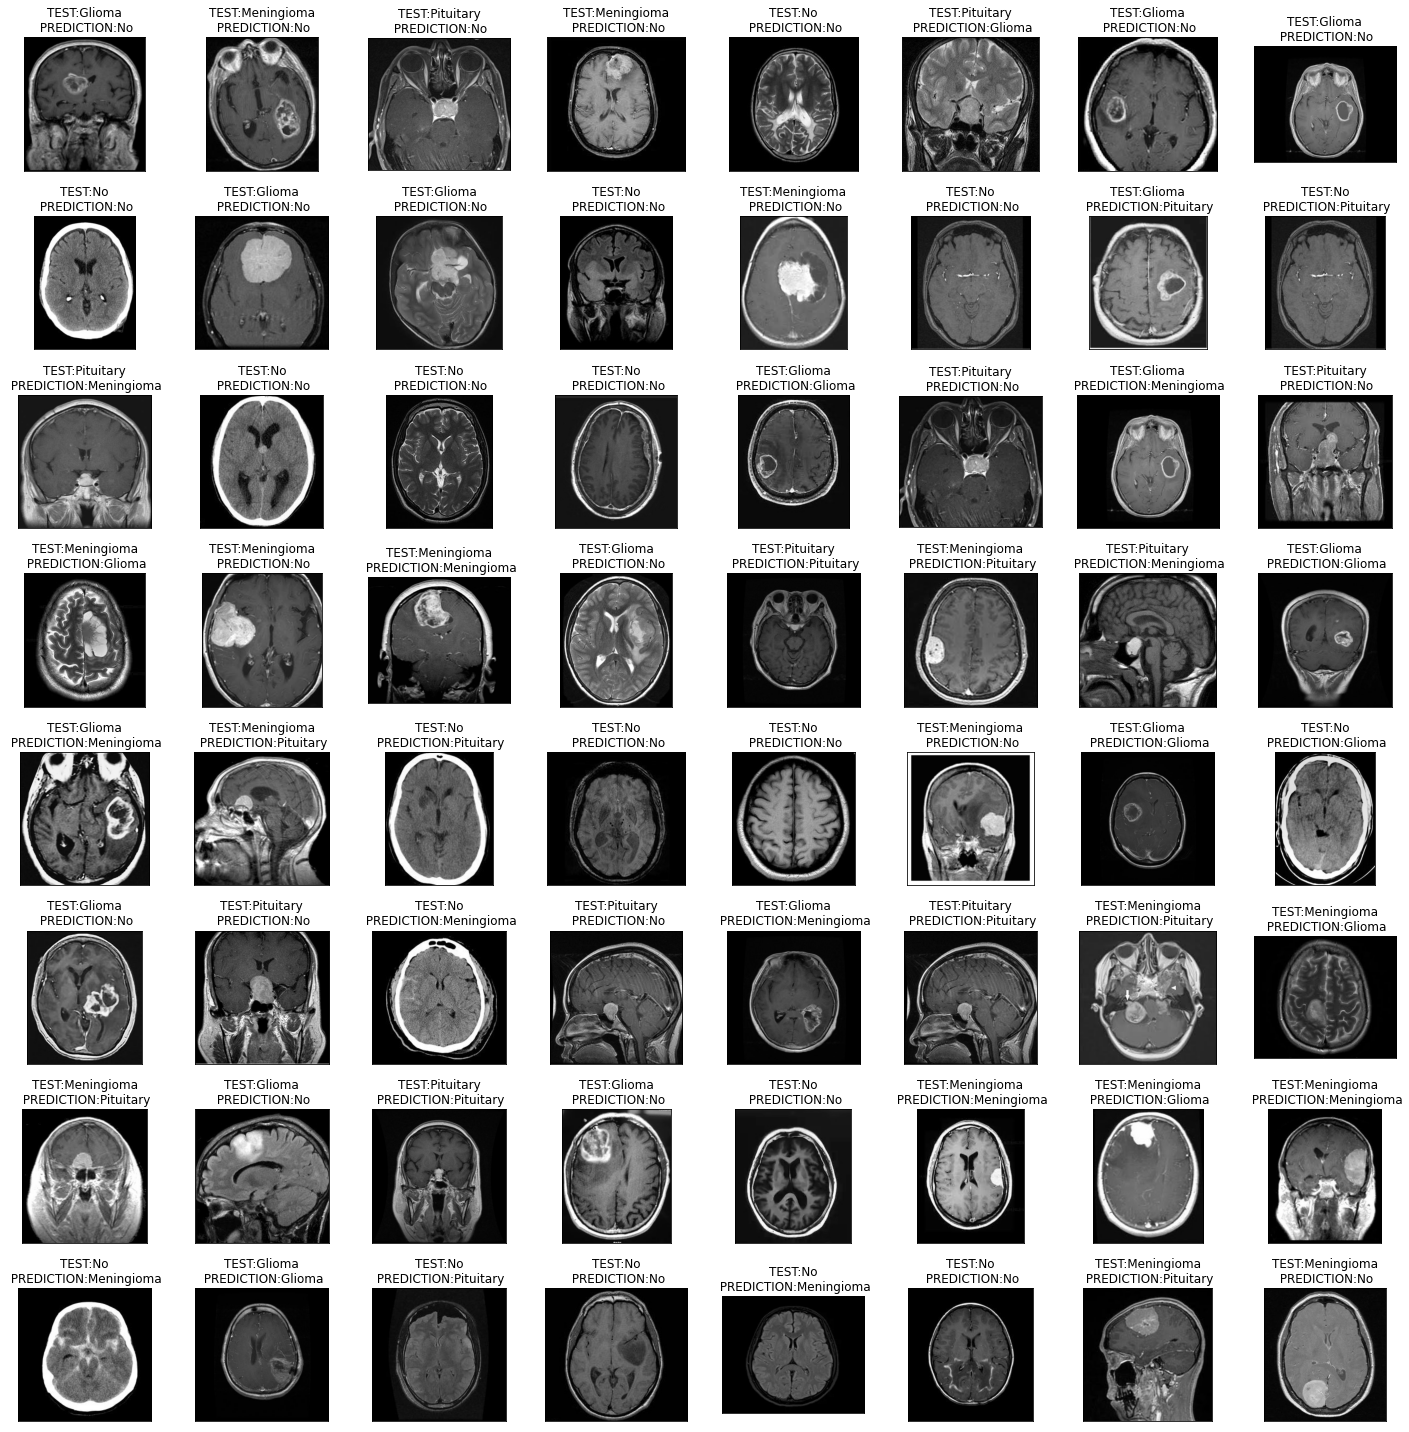

In [ ]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[i]))
    ax.set_title(f"TEST:{Main_Test_Data.TUMOR_CATEGORY.iloc[i]}\n PREDICTION:{Model_Predict[i]}")
plt.tight_layout()
plt.show()

# CNN MODEL 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
image_size=256

In [ ]:
S_CNN_model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.45))

S_CNN_model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.25))

S_CNN_model.add(tf.keras.layers.Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
S_CNN_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
S_CNN_model.add(tf.keras.layers.Dropout(0.25))

S_CNN_model.add(tf.keras.layers.Flatten())

S_CNN_model.add(tf.keras.layers.Dense(512, activation='relu'))
S_CNN_model.add(tf.keras.layers.Dropout(0.15))


S_CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Take a look at the model summary
#S_CNN_model.summary()

In [ ]:
S_CNN_model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

S_CNN_model.fit(Train_Set,epochs =2,validation_data=Validation_Set, verbose=1, batch_size=32,
                   )


Epoch 1/2
698/698 [==============================] - 61s 86ms/step - loss: 0.5917 - acc: 0.7460 - val_loss: 0.5624 - val_acc: 0.7500
Epoch 2/2
698/698 [==============================] - 59s 85ms/step - loss: 0.5629 - acc: 0.7500 - val_loss: 0.5625 - val_acc: 0.7500


In [ ]:
S_CNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_10 (MaxPoolin  (None, None, None, None)  0        
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, None, None, None)  0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 16)    3904      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, None, None, 16)    0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 36)   

In [ ]:
history = S_CNN_model.fit(Train_Set,epochs =2,validation_data=Validation_Set, verbose=1, batch_size=32,
                   callbacks=[TensorBoard,ModelCheckpoint,ReduceLROnPlateau])

In [ ]:
S_CNN_model_Results = S_CNN_model.evaluate(Test_Set,verbose=False)
print("LOSS:  " + "%.4f" % S_CNN_model_Results[0])
print("ACCURACY:  " + "%.2f" % S_CNN_model_Results[1])

LOSS:  0.5625
ACCURACY:  0.75


In [ ]:
print(S_CNN_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 256, 256, 16)      3904      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      20752     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 64, 64, 16)       

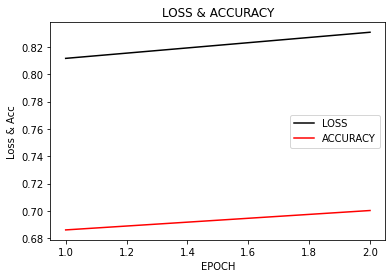

In [ ]:
plt.plot(epochs,val_losses,"k-",label="LOSS")
plt.plot(epochs,val_acc,"r",label="ACCURACY")
plt.title("LOSS & ACCURACY")
plt.xlabel("EPOCH")
plt.ylabel("Loss & Acc")
plt.legend()
plt.show()

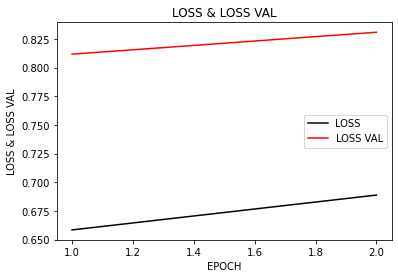

In [ ]:
plt.plot(epochs,losses,"k-",label="LOSS")
plt.plot(epochs,val_losses,"r",label="LOSS VAL")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

In [ ]:
S_CNN_Model_Predict = S_CNN_model.predict(Main_Test_Set)


In [ ]:
S_CNN_Model_Predict = np.argmax(S_CNN_Model_Predict,axis=1)


In [ ]:
Predict_Label = (Main_Test_Set.class_indices)
Predict_Label = dict((v,k) for k,v in Predict_Label.items())


In [ ]:
S_CNN_Model_Predict = [Predict_Label[k] for k in S_CNN_Model_Predict]


In [ ]:
print(S_CNN_Model_Predict[:50])

['Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma', 'Glioma']


In [ ]:
Test_Results = list(Main_Test_Data["TUMOR_CATEGORY"])

In [ ]:
print(Test_Results[:50])

['Glioma', 'Meningioma', 'Pituitary', 'Meningioma', 'No', 'Pituitary', 'Glioma', 'Glioma', 'No', 'Glioma', 'Glioma', 'No', 'Meningioma', 'No', 'Glioma', 'No', 'Pituitary', 'No', 'No', 'No', 'Glioma', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Glioma', 'Glioma', 'Meningioma', 'No', 'No', 'No', 'Meningioma', 'Glioma', 'No', 'Glioma', 'Pituitary', 'No', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma']


In [ ]:

print("S_CNN_Model_Predict Class_Report")
Class_Report = classification_report(Test_Results,S_CNN_Model_Predict)
print(Class_Report)


S_CNN_Model_Predict Class_Report
              precision    recall  f1-score   support

      Glioma       0.25      1.00      0.40       100
  Meningioma       0.00      0.00      0.00       115
          No       0.00      0.00      0.00       105
   Pituitary       0.00      0.00      0.00        74

    accuracy                           0.25       394
   macro avg       0.06      0.25      0.10       394
weighted avg       0.06      0.25      0.10       394



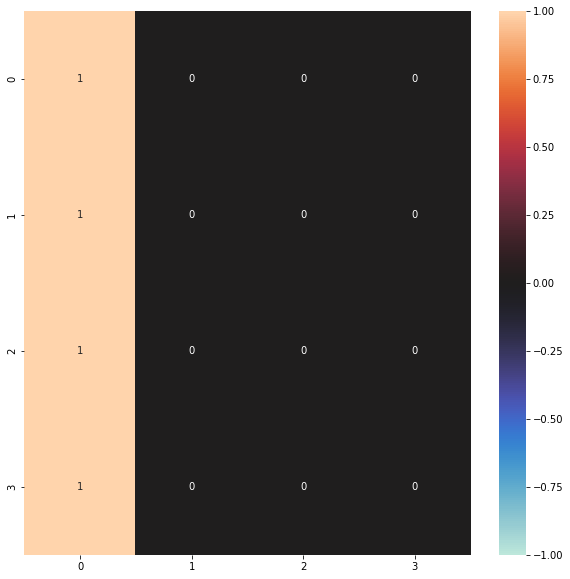

In [ ]:
Conf_Report = confusion_matrix(Test_Results,S_CNN_Model_Predict, normalize="true")
figure = plt.figure(figsize=(10,10))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

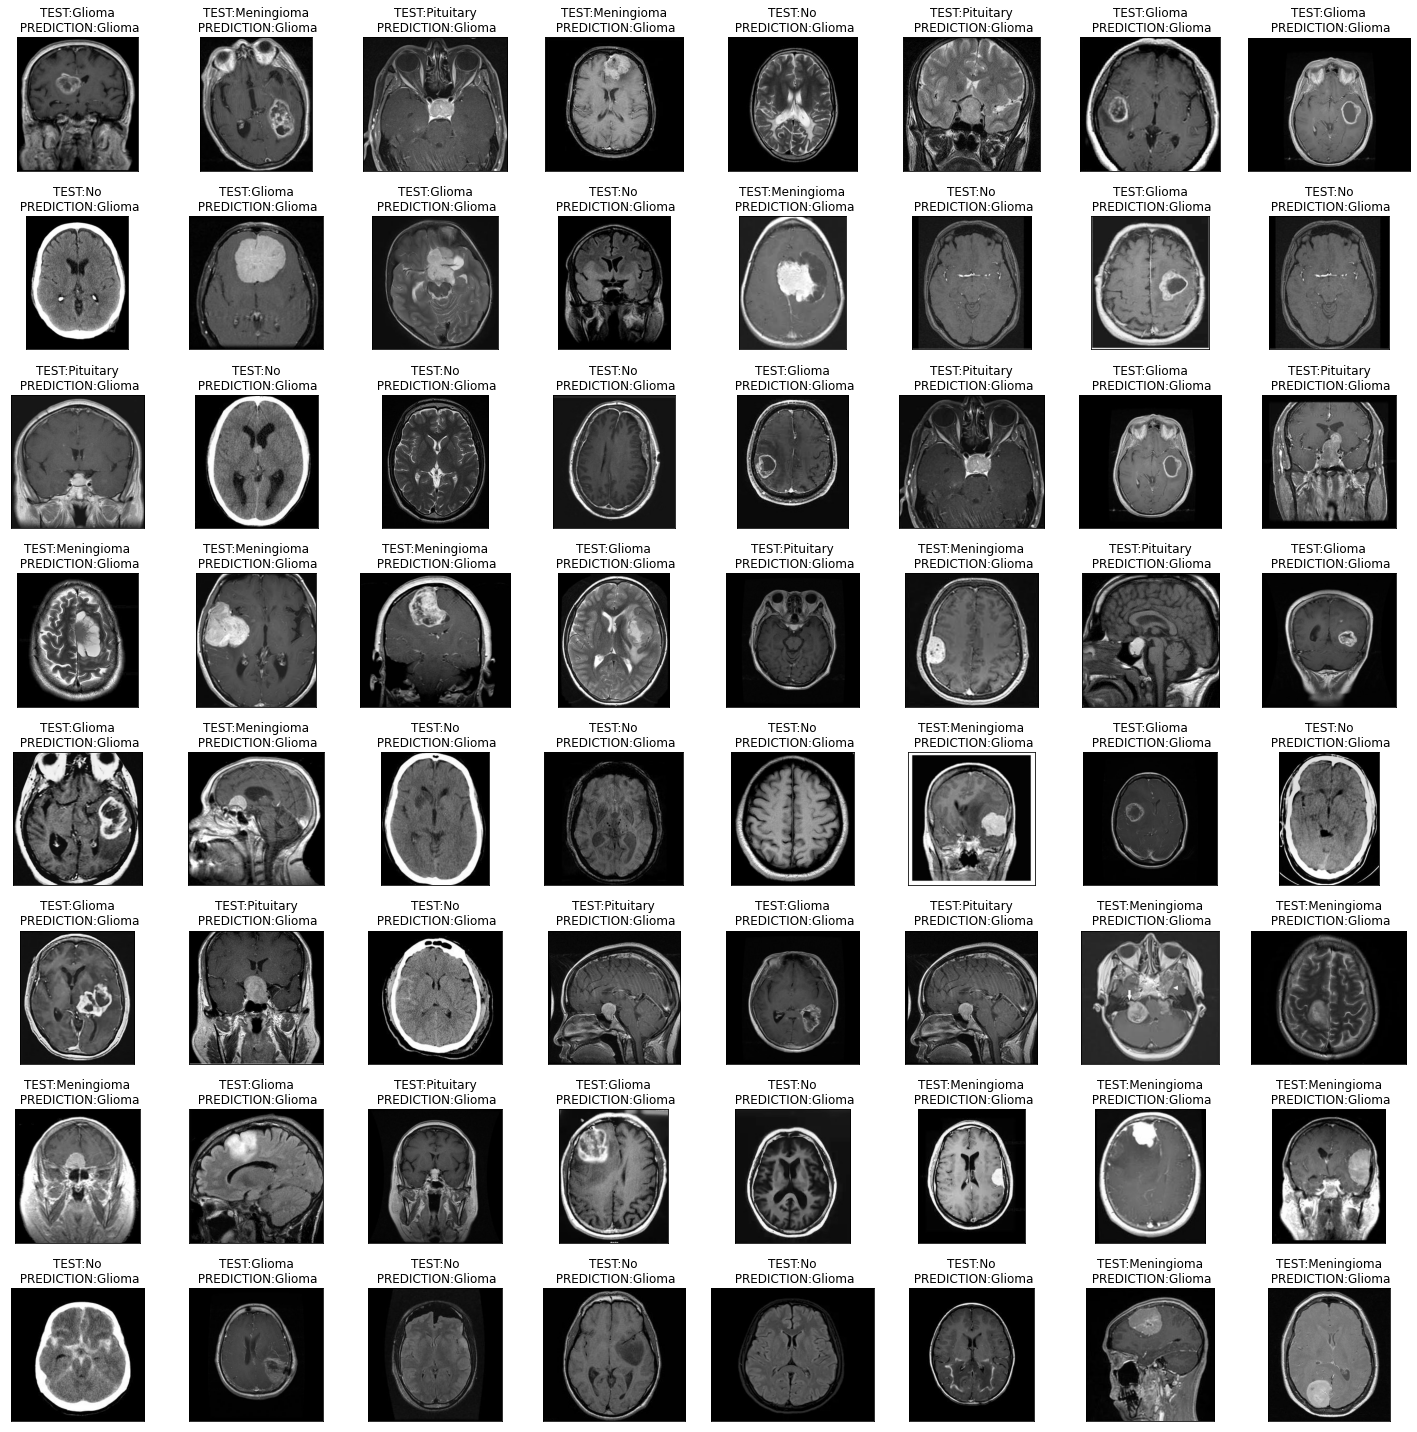

In [ ]:
fig, axes = plt.subplots(nrows=8,
                         ncols=8,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(Main_Test_Data["JPG"].iloc[i]))
    ax.set_title(f"TEST:{Main_Test_Data.TUMOR_CATEGORY.iloc[i]}\n PREDICTION:{S_CNN_Model_Predict[i]}")
plt.tight_layout()
plt.show()